In [1]:
import numpy as np
import math
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import copy
import os
import pickle
%matplotlib inline
sns.set_style("whitegrid")
colors = ["#1f77b4", "#ff7f0e", "#e377c2", "#bcbd22", "#7f7f7f", "#d62728", "#98df8a"]
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors) 

In [34]:
d, tcp = GaussianTestData(l=10)
print tcp

[4, 8]


{0.0: 6, 1.0: 4}
[ 0.5994006  0.3996004  0.000999 ]
[ 0.5994006  0.999001   1.       ]
----
[ 0.5994006  0.3996004  0.000999 ]
[ 0.5994006  0.999001   1.       ]
----
[ 0.5994006  0.3996004  0.000999 ]
[ 0.5994006  0.999001   1.       ]
----
[ 0.5994006  0.3996004  0.000999 ]
[ 0.5994006  0.999001   1.       ]
----
[ 0.5994006  0.3996004  0.000999 ]
[ 0.5994006  0.999001   1.       ]
----
[ 0.5994006  0.3996004  0.000999 ]
[ 0.5994006  0.999001   1.       ]
----
[ 0.5994006  0.3996004  0.000999 ]
[ 0.5994006  0.999001   1.       ]
----
[ 0.5994006  0.3996004  0.000999 ]
[ 0.5994006  0.999001   1.       ]
----
[ 0.5994006  0.3996004  0.000999 ]
[ 0.5994006  0.999001   1.       ]
----
[ 0.5994006  0.3996004  0.000999 ]
[ 0.5994006  0.999001   1.       ]
----
[ 0.999001  0.        0.000999]
[ 0.999001  0.999001  1.      ]
----
[ 0.999001  0.        0.000999]
[ 0.999001  0.999001  1.      ]
----
[ 0.999001  0.        0.000999]
[ 0.999001  0.999001  1.      ]
----
[ 0.999001  0.        0.00

/home/arne/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:62: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/arne/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/arne/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:49: RuntimeWarning: invalid value encountered in divide


[ 0.999001  0.        0.000999]
[ 0.999001  0.999001  1.      ]
----
[ 0.999001  0.        0.000999]
[ 0.999001  0.999001  1.      ]
----
[ 0.999001  0.        0.000999]
[ 0.999001  0.999001  1.      ]
----
[ 0.999001  0.        0.000999]
[ 0.999001  0.999001  1.      ]
----
[ 0.999001  0.        0.000999]
[ 0.999001  0.999001  1.      ]
----
[ 0.999001  0.        0.000999]
[ 0.999001  0.999001  1.      ]
----
[ 0.999001  0.        0.000999]
[ 0.999001  0.999001  1.      ]
----
[ 0.999001  0.        0.000999]
[ 0.999001  0.999001  1.      ]
----
[ 0.999001  0.        0.000999]
[ 0.999001  0.999001  1.      ]
----
[ 0.999001  0.        0.000999]
[ 0.999001  0.999001  1.      ]
----
[ 0.999001  0.        0.000999]
[ 0.999001  0.999001  1.      ]
----
[ 0.999001  0.        0.000999]
[ 0.999001  0.999001  1.      ]
----
[ 0.999001  0.        0.000999]
[ 0.999001  0.999001  1.      ]
----
[ 0.999001  0.        0.000999]
[ 0.999001  0.999001  1.      ]
----
[ 0.999001  0.        0.000999]
[ 

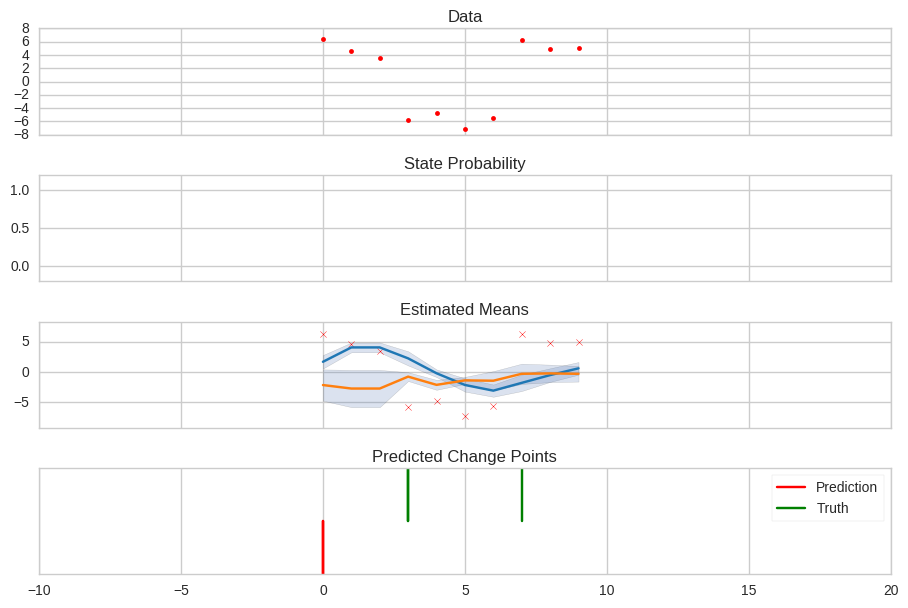

In [46]:
cpd = BootstrapFilterCRP()
z2,m2,v2, cp2 = cpd.run(d)
plotMultiStateParticleSub(d, z2, m2, v2, cp2, tcp)

In [45]:
class BootstrapFilterCRP(object):
    
    def __init__(self, likelihood=(0,1), prior=(1,-1), N=10, \
                 noise = 0.1, alpha=0.01):
        
        self.noise = noise
        self.likelihood = likelihood
        self.numStates = len(prior)
        self.prior = prior
        
        self.cp = []
        self.prevMax = -1
        self.t=1
        self.alpha = alpha
        

        self.weights = np.ones(N)            
        state = np.random.randint(0, high=len(prior), size=N)
        p = [state]
        for a in prior:
            p.append(np.random.normal(loc=a, size=N))
        self.particles = np.stack(p, axis=-1)
        
        unique, counts = np.unique(self.particles[:,0], return_counts=True)
        self.d = dict(zip(unique, counts))
        print self.d
                  
    def update(self, datum):
        for i, p in enumerate(self.particles):
            self.particles[i] = self.markovTransition(p)
            #weightParticle
            self.weights[i] = scipy.stats.norm(datum, \
                    1).pdf(p[p[0]+1])
        #normalise weights
        weightSum = np.sum(self.weights)
        self.weights = self.weights/weightSum
        if 1. / np.sum(np.square(self.weights)) < len(self.weights) / 2:            
            self.multinomialResampling()          
        
        self.mean = []
        var = []
        z = np.zeros(self.numStates)
        unique, counts = np.unique(self.particles[:,0], return_counts=True)
        self.d = dict(zip(unique, counts))
        for i in range(self.numStates):
            p = [x[1+i] for x in self.particles]
            self.mean.append(np.mean(p))
            var.append(np.var(p))
            if i in d:
                z[i] = self.d[i]
        z = z/np.sum(z)
        if not self.prevMax == z.argmax():
            self.cp.append(self.t)
        self.prevMax = z.argmax()
        self.t += 1
        return z, self.mean, var
        
    def markovTransition(self, p):
        observations = len(self.weights)#self.t
        stateProbList = np.zeros(self.numStates+1)
        #probs for existing states
        for state in self.d:
            #print state
            stateProbList[state] = self.d[state]/(observations+self.alpha)
        #prob for new state
        stateProbList[-1] = self.alpha/(observations+self.alpha)
        #draw a state
        cumsum = np.cumsum(stateProbList)
        cumsum[-1] = 1
        state = np.searchsorted(cumsum, np.random.uniform())
        print stateProbList
        print cumsum
        print '----'
        if state >= self.numStates:
            print 'new state'
            #do stuff
            #add a new theta too all paricles 
        p[0]=state
        return p
        
    def multinomialResampling(self):
        N = len(self.weights)
        cumsum = np.cumsum(self.weights)
        cumsum[-1] = 1
        uniform = np.random.uniform(size=N)
        indexes = np.searchsorted(cumsum, uniform)
        # resample according to indexes        
        self.particles = self.particles[indexes]
        for i,t in enumerate(self.particles[0,1:]):
            self.particles[:,i+1] += np.random.normal(scale=1,size=N)
        self.weights.fill(1.0 / N)
    
    def run(self, data):
        particles = []
        z = []
        mean = []
        var = []
        for i, d in enumerate(data):
            z_t, m, v = self.update(d)        
            z.append(list(z_t))
            mean.append(list(m))
            var.append(list(v))
        return z, mean, var, self.cp
    
    def getBCPinfo(self):
        maxZ = self.prevMax
        return self.mean[maxZ]

In [3]:
class BootstrapFilterOpperMultiState(object):
    
    def __init__(self, d=1, likelihood=(0,1), prior=(1,-1), N=2000, \
                 noise = 0.1, particles=None,):
        
        self.noise = noise
        self.likelihood = likelihood
        self.numStates = len(prior)
        self.prior = prior
        
        self.cp = []
        self.prevMax = -1
        self.t=1
        
        if particles is not None:
            self.particles = particles
            self.weights = np.ones(len(self.particles))
        else:
            self.weights = np.ones(N)            
            state = np.random.randint(0, high=len(prior), size=N)
            p = [state]
            for a in prior:
                p.append(np.random.normal(loc=a, size=N))
            self.particles = np.stack(p, axis=-1)
                  
    def update(self, datum):
        for i, p in enumerate(self.particles):
            self.particles[i] = self.markovTransition(p)
            #weightParticle
            self.weights[i] = scipy.stats.norm(datum, \
                    1).pdf(p[p[0]+1])
        #normalise weights
        weightSum = np.sum(self.weights)
        self.weights = self.weights/weightSum
        if 1. / np.sum(np.square(self.weights)) < len(self.weights) / 2:            
            self.multinomialResampling()          
        
        self.mean = []
        var = []
        z = np.zeros(len(self.prior))
        unique, counts = np.unique(self.particles[:,0], return_counts=True)
        d = dict(zip(unique, counts))
        for i in range(len(self.prior)):
            p = [x[1+i] for x in self.particles]
            self.mean.append(np.mean(p))
            var.append(np.var(p))
            if i in d:
                z[i] = d[i]
        z = z/np.sum(z)
        if not self.prevMax == z.argmax():
            self.cp.append(self.t)
        self.prevMax = z.argmax()
        self.t += 1
        return z, self.mean, var
        
    def markovTransition(self, p):
        if np.random.rand() < 0.9 or self.numStates == 1:
            return p
        else:
            newState = np.random.randint(0, high=self.numStates)
            while newState == p[0]:
                newState = np.random.randint(0, high=self.numStates)
            p[0] = newState 
        return p
        
    def multinomialResampling(self):
        N = len(self.weights)
        cumsum = np.cumsum(self.weights)
        cumsum[-1] = 1
        uniform = np.random.uniform(size=N)
        indexes = np.searchsorted(cumsum, uniform)
        # resample according to indexes        
        self.particles = self.particles[indexes]
        for i,t in enumerate(self.particles[0,1:]):
            self.particles[:,i+1] += np.random.normal(scale=1,size=N)
        self.weights.fill(1.0 / N)
    
    def run(self, data):
        particles = []
        z = []
        mean = []
        var = []
        for i, d in enumerate(data):
            z_t, m, v = self.update(d)        
            z.append(list(z_t))
            mean.append(list(m))
            var.append(list(v))
        return z, mean, var, self.cp
    
    def getBCPinfo(self):
        maxZ = self.prevMax
        return self.mean[maxZ]

In [4]:

def plotMultiStateParticleSub(data, z, m, v, cp, trueCP):
    f, axarr = plt.subplots(4, sharex=True, figsize=(9, 6))
    axarr[0].set_xlim([-10,len(data)+10])
################ PREPARE DATA ################     
    states = len(z[0])
    zData = []
    meanData = []
    varData = []
    for i in range(states):
        zData.append(([],range(len(data))))
        meanData.append(([],range(len(data))))
        varData.append(([],range(len(data))))
    for t,z_t in enumerate(z):
        if len(z_t)>states:
            states += 1
            zData.append(([],range(t,len(data))))
            meanData.append(([],range(t,len(data))))
            varData.append(([],range(t,len(data))))
        for i,z_t_i in enumerate(z_t):
            zData[i][0].append(z_t_i)
            meanData[i][0].append(m[t][i])
            varData[i][0].append(v[t][i])
################ PLOT DATA ################ 
    axarr[0].plot(range(0,len(data)), data, 'r.')
    axarr[0].set_title("Data")
################ PLOT Z ################ 
    for z in zData:
        axarr[1].plot(z[1][:len(z[0])], z[0])
    axarr[1].set_ylim([-0.2,1.2])
    axarr[1].set_title("State Probability")
    axarr[1].set_yticks((0,0.5,1))
################ PLOT MEAN AND VAR################      
    for m, v in zip(meanData, varData):
        lowV = [mi-vi for (mi, vi) in zip(m[0],v[0])]
        highV = [mi+vi for (mi, vi) in zip(m[0],v[0])]
        axarr[2].plot(m[1][:len(m[0])], m[0])
        axarr[2].fill_between(m[1][:len(m[0])], lowV, highV, alpha=0.2)
    axarr[2].set_title("Estimated Means")
    axarr[2].set_ylim(min(data)-2, max(d)+2)
    axarr[2].scatter(range(0,len(data)), data, marker='x', color='red')
############### CHANGEPOINT ANALYSIS ##################
    for p in cp:
        axarr[3].axvline(x=p-1, ymin=0, ymax = 0.5, color='red', alpha=1.0)
    for p in trueCP:
        axarr[3].axvline(x=p-1, ymin=0.5, ymax = 1, color='green', alpha=1.0)
    axarr[3].axvline(x=cp[0]-1, ymin=0, ymax = 0.5, color='red', alpha=1.0, label='Prediction')
    axarr[3].axvline(x=trueCP[0]-1, ymin=0.5, ymax = 1, color='green', alpha=1.0, label='Truth')
    axarr[3].grid(axis='y')
    axarr[3].set_yticks(())
    axarr[3].set_title("Predicted Change Points")
    axarr[3].legend(frameon=True, framealpha=0.6)
    
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [5]:
def markovTransition(p,n):
    if np.random.rand() < 0.95 or n==1:
        return p, False
    else:
        newState = np.random.randint(0, high=n)
        while newState == p:
            newState = np.random.randint(0, high=n)
        p = newState                
    return p, True

In [6]:
def GaussianTestData(mean=[-5,5], var=[1,1], l=500):
    if len(mean) != len(var):
        raise Exception("mean and var need to have the same amount of values")
    n = len(mean)
    currState = np.random.randint(n)
    states = []
    data = []
    trueCP = []
    for i in range(l):
        currState, cp = markovTransition(currState,n)
        states.append(currState)
        x = np.random.normal(loc=mean[currState] , scale=var[currState])
        data.append(x)
        if cp:
            trueCP.append(i+1)
    return data, trueCP